In [1]:
import sys
sys.path.append('/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample')
import torch
import torchvision
torch.manual_seed(5)

from src.network.feature_extractor import CNN
from src.network.Classification import LLVIClassification
from src.network import LikApprox, PredictApprox
from src.weight_distribution.Full import FullCovariance
from datetime import datetime

In [2]:
print("test")

test


In [3]:
batch_size_train = 32
batch_size_test = 1000
filepath = "/Users/philippvonbachmann/Documents/University/WiSe2122/ResearchProject/ResearchProjectLLVI/BasicExample/datasets/Classification"
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST(filepath, train=True, download=False,
                            transform=torchvision.transforms.Compose([
                              torchvision.transforms.ToTensor(),
                              torchvision.transforms.Normalize(
                                (0.1307,), (0.3081,))
                            ])),
  batch_size=batch_size_train, shuffle=True)
n_datapoints = batch_size_train * len(train_loader)

/opt/homebrew/Caskroom/miniforge/base/envs/DeepLearning/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1635217266490/work/torch/csrc/utils/tensor_numpy.cpp:189.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# go over all mc methods
lr = 1e-4
samples_list = [1,10]
mc_train_losses = []
mc_train_times = []
for samples in samples_list:
    print("Starting run", samples)
    feature_extractor = CNN(optimizer=torch.optim.Adam, lr=lr, weight_decay=5e-4)
    dist = FullCovariance(50, 10, lr=lr)
    net_mc = LLVIClassification(50, 10, feature_extractor, dist,
    prior_log_var=-1, optimizer_type=torch.optim.Adam,
    tau=0.1, lr=lr)
    start_time = datetime.now()
    train_loss = net_mc.train_model(train_loader, epochs=5, n_datapoints=n_datapoints, samples=samples, method=LikApprox.MONTECARLO)
    total_time = int((datetime.now() - start_time).total_seconds())
    mc_train_losses.append(train_loss)
    mc_train_times.append(total_time)

Starting run 1


prediction_loss:2.0 kl_loss:0.01: 100%|██████████| 5/5 [03:27<00:00, 41.53s/it] 


Starting run 10


prediction_loss:1.21 kl_loss:0.01: 100%|██████████| 5/5 [03:36<00:00, 43.38s/it]


In [5]:
approx_list = ["jennsen", "bohning", "multidelta"]
cf_train_losses = []
cf_train_times = []
for approx_name in approx_list:
    print("Starting approx", approx_name)
    feature_extractor = CNN(optimizer=torch.optim.Adam, lr=lr, weight_decay=5e-4)
    dist = FullCovariance(50, 10, lr=lr)
    net_cf = LLVIClassification(50, 10, feature_extractor, dist,
    prior_log_var=-1, optimizer_type=torch.optim.Adam,
    tau=0.1, lr=lr)
    start_time = datetime.now()
    train_loss = net_cf.train_model(train_loader, epochs=5, n_datapoints=n_datapoints, samples=5, method=LikApprox.CLOSEDFORM, approx_name=approx_name)
    cf_train_losses.append(train_loss)
    cf_train_times.append(int((datetime.now() - start_time).total_seconds()))

Starting approx jennsen


prediction_loss:nan kl_loss:nan: 100%|██████████| 5/5 [05:18<00:00, 63.64s/it]


Starting approx bohning


prediction_loss:2.3 kl_loss:0.01: 100%|██████████| 5/5 [05:40<00:00, 68.05s/it] 


Starting approx multidelta


prediction_loss:2.28 kl_loss:0.01: 100%|██████████| 5/5 [06:34<00:00, 78.81s/it] 


NameError: name 'samples_list' is not defined

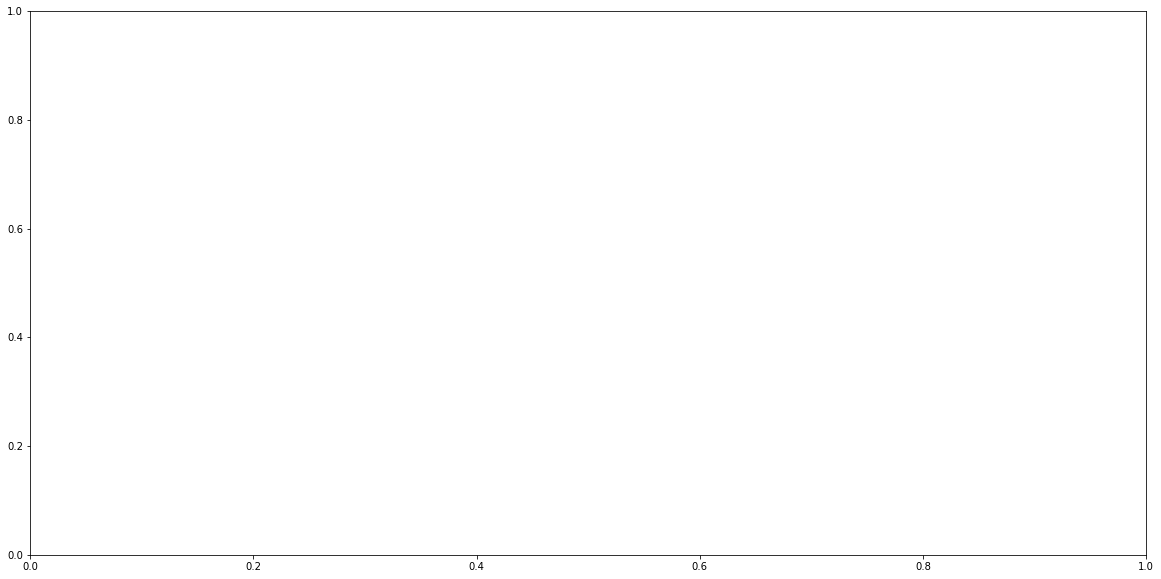

In [1]:
# visualization
from matplotlib import pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
vi_train_epochs=5
for samples, train_loss, train_time in zip(samples_list, mc_train_losses, mc_train_times):
    ax.plot(list(range(vi_train_epochs)), (train_loss["prediction_loss"]), label=f"samples:{samples}, total time:{train_time}s")

for approx_name, train_loss, train_time in zip(approx_list, cf_train_losses, cf_train_times):
    ax.plot(list(range(vi_train_epochs)), (train_loss["prediction_loss"]), label=f"{approx_name}, total time:{train_time}s") 

ax.legend()
ax.set_ylim(0, 1)
ax.set_xlim(0, 5)
fig.suptitle("Monte Carlo vs Closed Form Classification Loss comparison")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")